# LOS Prediction - Feedforward Deep Neural Network

This notebook predicts the hospital length of stay using the first 24 or 48 hour processed MIMIC-III dataset.

Here, we attempt to train with varying layers, hidden units, and other tunable hyperparameters to achieve the optimal performance on the validation set. 

Later on, we try to improve the performance by running feature selection before hand. For that see `los_prediction_after_feature_selection` notebook.



In [156]:
from __future__ import absolute_import, division, print_function, unicode_literals

import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from keras.layers.advanced_activations import LeakyReLU

import numpy as np

print(tf.__version__)

2.0.0


In [157]:

raw_dataset = pd.read_csv('../data/exp/pneumonia-t3/first48hours.csv', header=0)
df = raw_dataset.copy()

df = df.loc[:, (df==0).mean() < .7]
df.fillna(0, inplace=True)
df = df.replace([np.inf, -np.inf], 0)

# Remove rows where the chartevents aren't available
df = df[df['Heart Rate'] > 0]

# Remove outliers
df = df[df['los'] <= 100]

# Shuffle data because data is ordered by admittime currently
df = df.sample(frac=1).reset_index(drop=True)
df.tail()


,los,age,gender,insurance,language,religion,marital_status,ethnicity,Anion Gap,Anion Gap-trend,...,Systolic,Systolic-trend,O2 Flow.1,O2 Flow-trend.1,Respiratory Rate,Respiratory Rate-trend,Temperature.1,Temperature-trend.1,O2,O2-trend
3877,5.562,91.4000,M,Medicare,0,CATHOLIC,WIDOWED,WHITE,11.000,0.084,...,115.675,0.512,33.533,-1.987,57.727,-0.068,36.604,-0.025,0.000,0.000
3878,29.817,21.4187,M,Private,0,CATHOLIC,SINGLE,WHITE,13.667,-0.019,...,110.188,0.340,0.000,0.000,57.089,-0.075,56.866,-0.009,0.000,0.000
3879,12.883,81.0750,F,Medicare,ENGL,NOT SPECIFIED,MARRIED,WHITE,14.500,0.035,...,107.176,-0.651,0.000,0.000,15.115,-0.112,0.000,0.000,95.923,-0.005
3880,4.186,91.4000,F,Medicare,ENGL,CATHOLIC,SINGLE,WHITE,16.000,-0.000,...,124.760,0.193,2.000,-0.000,24.280,0.072,0.000,0.000,95.440,-0.128
3881,6.631,91.4000,F,Medicare,0,UNOBTAINABLE,WIDOWED,WHITE,14.333,-0.007,...,105.156,-0.380,3.286,0.044,58.306,-0.476,37.432,-0.065,0.000,0.000


In [158]:
# One hot encode the demographic columns
# (comment out if we don't want to use the demographic columns at all)
# 
cols_to_one_hot = ['gender', 'insurance', 'language', 'religion', 'marital_status', 'ethnicity']
for col in cols_to_one_hot:
    one_hot = pd.get_dummies(df[col], col)
    df = df.drop(col, axis = 1)
    df = df.join(one_hot)
los = df.pop('los')

Num columns: 213
Num rows: 3882


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:1185: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


Training (LOS): 5.4880306208090515
Validation (LOS): 6.644783289677404
Testing (LOS): 6.547327730822475


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/stats/stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


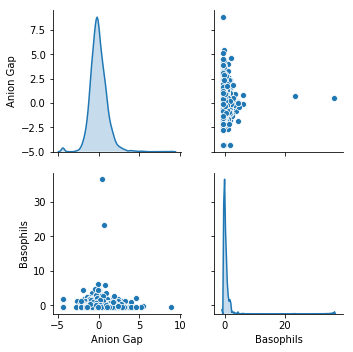

In [159]:
from sklearn.linear_model import SGDClassifier, SGDRegressor, LogisticRegression, LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import ElasticNet
from math import sqrt
from sklearn.feature_selection import f_regression, mutual_info_regression, SelectKBest


# NORMALIZE THE DATASET
stats = df.describe()
stats = stats.transpose()

def norm(x):
  return (x - stats['mean']) / stats['std']
normed_df = norm(df)

print("Num columns: " + str(len(normed_df.columns)))
print("Num rows: " + str(len(df.values)))

# DIVIDE INTO TRAIN/TEST
normed_df.insert(0, 'los', los)
train_dataset = normed_df.sample(frac=0.7)
test_dataset = normed_df.drop(train_dataset.index)
train_labels = train_dataset.pop('los')
test_labels = test_dataset.pop('los')

#print(test_labels)
X_train, X_val, y_train, y_val = train_test_split(train_dataset, train_labels, test_size=0.70)

# normed_train_data

clf = SGDRegressor(loss="squared_loss", penalty="l1", eta0=0.0001)
# clf = LinearRegression(normalize=True)
clf.fit(X_train, y_train)

y_train_preds = clf.predict(X_train)
training_error = mean_absolute_error(y_train, y_train_preds)
print("Training (LOS): " + str(training_error))

y_val_preds = clf.predict(X_val)
training_error = mean_absolute_error(y_val, y_val_preds)
print("Validation (LOS): " + str(training_error))

y_test_preds = clf.predict(test_dataset)
test_error = mean_absolute_error(test_labels, y_test_preds)
print("Testing (LOS): " + str(test_error))

sns.pairplot(train_dataset[["Anion Gap", "Basophils"]], diag_kind="kde")


In [173]:
# https://stats.stackexchange.com/questions/181/how-to-choose-the-number-of-hidden-layers-and-nodes-in-a-feedforward-neural-netw
def build_model():
  model = keras.Sequential([
    layers.Dense(12, activation='relu', input_shape=[len(train_dataset.keys())]),
    layers.Dropout(0.5, name='dropout_1'),
    layers.Dense(12, activation='relu', input_shape=[len(train_dataset.keys())]),
#     layers.Dropout(0.5, name='dropout_2'),
#     layers.Dense(12, activation='relu', input_shape=[len(train_dataset.keys())]),
#     layers.Dense(512, kernel_initializer='normal',activation='relu'),
#     layers.Dropout(0.5, name='dropout_1'),
#     layers.Dense(512, kernel_initializer='normal',activation='relu'),
#     layers.Dropout(0.5, name='dropout_2'),
#     layers.Dense(512, kernel_initializer='normal',activation='relu'),
    layers.Dense(1)
  ])

#   optimizer = tf.keras.optimizers.RMSprop(0.001)
  optimizer = 'adam'

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

model = build_model()

In [174]:

from sklearn.model_selection import KFold

# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 40

history = model.fit(
      train_dataset, train_labels,
      epochs=EPOCHS, validation_split = 0.2, verbose=0,
      callbacks=[PrintDot()])

# # X_train, X_val, y_train, y_val = train_test_split(train_dataset, train_labels, test_size=0.70)
# kfold = KFold(n_splits=10, shuffle=True)
# scores = []
# for train_index, test_index in kfold.split(train_dataset):
#     model = build_model()
#     history = model.fit(
#       train_dataset[train_index], train_labels[train_index],
#       epochs=EPOCHS, validation_split = 0.2, verbose=0,
#       callbacks=[PrintDot()])
#     scores.append(hist["val_mae"][10:].mean())
    
#     actual_predictions = model.predict(test_dataset)
#     test_error = mean_absolute_error(test_labels, actual_predictions)
#     print("Testing (LOS): " + str(test_error))
    
# print("Training (LOS): " + str(np.mean(scores)))




........................................

In [175]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()
print("Training (LOS):" + str(hist["mae"][10:].mean()))
print("Validation (LOS):" + str(hist["val_mae"][10:].mean()))

### Assess test error

actual_predictions = model.predict(test_dataset)
test_error = mean_absolute_error(test_labels, actual_predictions)
print("Testing (LOS): " + str(test_error))


Training (LOS):5.745979420344034
Validation (LOS):5.922368208567302
Testing (LOS): 5.972462361059884


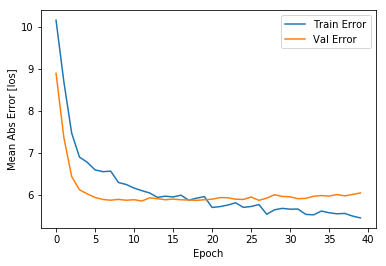

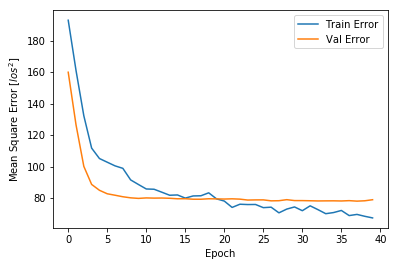

In [176]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [los]')
  plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
  #plt.ylim([0,max(hist['val_mae'])])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$los^2$]')
  plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
  #plt.ylim([0,max(hist['val_mse'])])
  plt.legend()
  plt.show()


plot_history(history)

# hist = pd.DataFrame(history.history)
# hist['val_mae']